<a href="https://colab.research.google.com/github/romezb/test/blob/main/Stock_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [10]:
# Install required packages
!pip install pandas numpy matplotlib seaborn scikit-learn tensorflow

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import warnings
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [11]:
# Load the dataset
df = pd.read_csv('stock_data.csv', index_col=0, parse_dates=True)

# Quick dataset info
print("📊 DATASET LOADED SUCCESSFULLY!")
print(f"Shape: {df.shape}")
print(f"Stocks: {list(df.columns)}")
print(f"Date range: {df.index[0].date()} to {df.index[-1].date()}")

📊 DATASET LOADED SUCCESSFULLY!
Shape: (365, 5)
Stocks: ['Stock_1', 'Stock_2', 'Stock_3', 'Stock_4', 'Stock_5']
Date range: 2020-01-01 to 2020-12-30


In [12]:
# Data Preprocessing for LSTM
def create_sequences(data, sequence_length):
    """
    Create sequences for LSTM training
    """
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:(i + sequence_length)])
        y.append(data[i + sequence_length])
    return np.array(X), np.array(y)

# Let's focus on Stock_1 for this example
target_stock = 'Stock_1'
data = df[target_stock].values.reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Split data into train and test sets
train_size = int(len(scaled_data) * 0.8)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size:]

# Create sequences
sequence_length = 20  # Look back 20 days
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)

print(f"Training data shape: {X_train.shape}")
print(f"Testing data shape: {X_test.shape}")

Training data shape: (272, 20, 1)
Testing data shape: (53, 20, 1)


In [13]:
# Build LSTM Model
def build_lstm_model(sequence_length, features=1):
    model = Sequential([
        LSTM(50, return_sequences=True, input_shape=(sequence_length, features)),
        Dropout(0.2),
        LSTM(50, return_sequences=True),
        Dropout(0.2),
        LSTM(50),
        Dropout(0.2),
        Dense(25),
        Dense(1)
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='mean_squared_error',
        metrics=['mae']
    )

    return model

# Build and display model
model = build_lstm_model(sequence_length)
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 20, 50)         │        10,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 20, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_4 (LSTM)                   │ (None, 20, 50)         │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 20, 50)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        20,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 52,101 (203.52 KB)

 Trainable params: 52,101 (203.52 KB)

 Non-trainable params: 0 (0.00 B)

In [14]:
# NOW Train the model (this should work without errors)
history = model.fit(
    X_train, y_train,
    batch_size=32,
    epochs=50,  # Reduced from 100 to 50 for faster training
    validation_data=(X_test, y_test),
    verbose=1,
    shuffle=False
)

Epoch 1/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 8s 163ms/step - loss: 0.1999 - mae: 0.3973 - val_loss: 0.0992 - val_mae: 0.3125
Epoch 2/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0549 - mae: 0.1918 - val_loss: 0.0134 - val_mae: 0.1013
Epoch 3/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 94ms/step - loss: 0.0294 - mae: 0.1405 - val_loss: 0.0355 - val_mae: 0.1831
Epoch 4/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0190 - mae: 0.1135 - val_loss: 0.0201 - val_mae: 0.1332
Epoch 5/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0229 - mae: 0.1239 - val_loss: 0.0246 - val_mae: 0.1503
Epoch 6/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step - loss: 0.0172 - mae: 0.1083 - val_loss: 0.0220 - val_mae: 0.1417
Epoch 7/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step - loss: 0.0178 - mae: 0.1093 - val_loss: 0.0171 - val_mae: 0.1230
Epoch 8/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0146 - mae: 0.0998 - val_loss: 0.0193 - val_mae: 0.1326
Epoch 9/50
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - loss: 0.0167 - mae: 0.1083 -

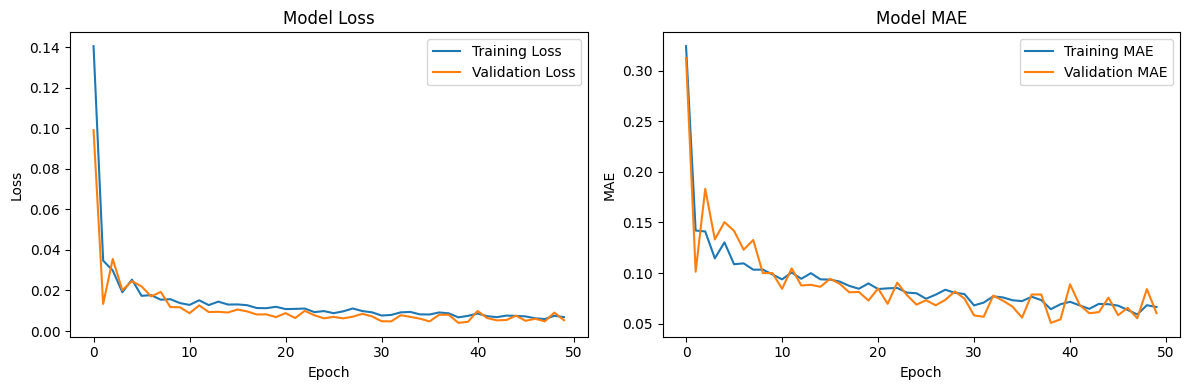

In [15]:
# Plot training history
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.title('Model MAE')
plt.xlabel('Epoch')
plt.ylabel('MAE')
plt.legend()

plt.tight_layout()
plt.show()

In [16]:
# Make predictions
train_predictions = model.predict(X_train)
test_predictions = model.predict(X_test)

# Inverse transform predictions
train_predictions = scaler.inverse_transform(train_predictions)
test_predictions = scaler.inverse_transform(test_predictions)

# Inverse transform actual values
y_train_actual = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 225ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 107ms/step


In [17]:
# Calculate metrics
def calculate_metrics(actual, predicted):
    mse = mean_squared_error(actual, predicted)
    mae = mean_absolute_error(actual, predicted)
    rmse = np.sqrt(mse)

    # Calculate MAPE (Mean Absolute Percentage Error)
    mape = np.mean(np.abs((actual - predicted) / actual)) * 100

    return mse, mae, rmse, mape

train_mse, train_mae, train_rmse, train_mape = calculate_metrics(y_train_actual, train_predictions)
test_mse, test_mae, test_rmse, test_mape = calculate_metrics(y_test_actual, test_predictions)

print("Training Metrics:")
print(f"MSE: {train_mse:.4f}, MAE: {train_mae:.4f}, RMSE: {train_rmse:.4f}, MAPE: {train_mape:.2f}%")

print("\nTesting Metrics:")
print(f"MSE: {test_mse:.4f}, MAE: {test_mae:.4f}, RMSE: {test_rmse:.4f}, MAPE: {test_mape:.2f}%")

Training Metrics:
MSE: 3.4892, MAE: 1.4997, RMSE: 1.8679, MAPE: 1.37%

Testing Metrics:
MSE: 4.9322, MAE: 1.8369, RMSE: 2.2209, MAPE: 1.90%


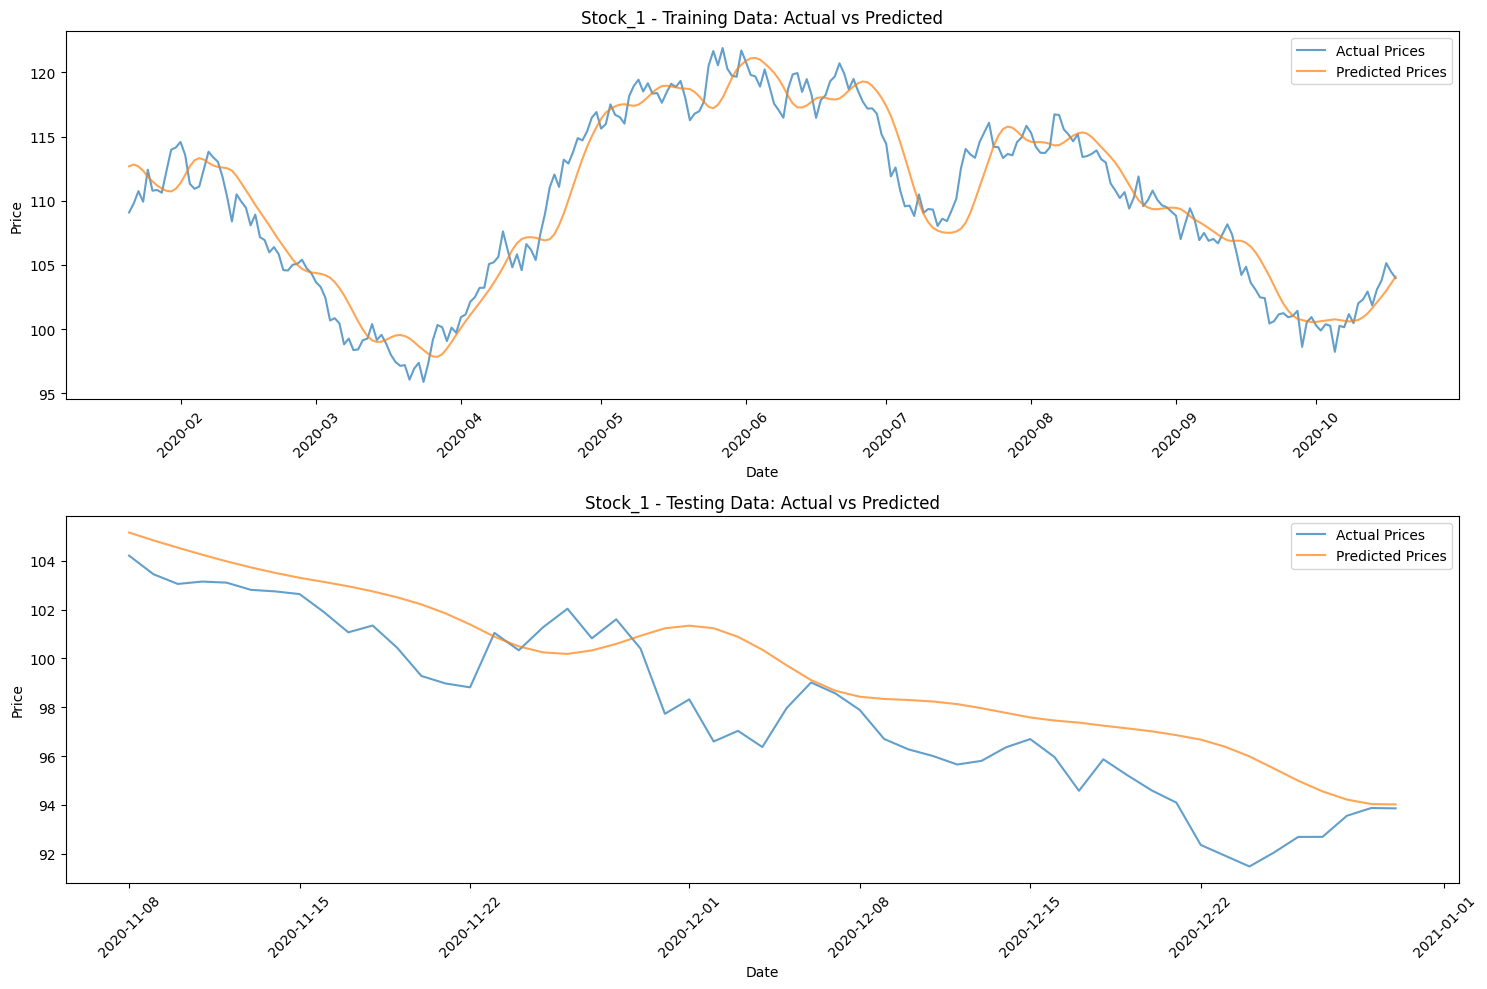

In [18]:
# Visualize predictions
plt.figure(figsize=(15, 10))

# Create time indices for plotting
train_indices = df.index[sequence_length:train_size]
test_indices = df.index[train_size + sequence_length:train_size + sequence_length + len(test_predictions)]

# Plot training predictions
plt.subplot(2, 1, 1)
plt.plot(train_indices, y_train_actual, label='Actual Prices', alpha=0.7)
plt.plot(train_indices, train_predictions, label='Predicted Prices', alpha=0.7)
plt.title(f'{target_stock} - Training Data: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)

# Plot testing predictions
plt.subplot(2, 1, 2)
plt.plot(test_indices, y_test_actual, label='Actual Prices', alpha=0.7)
plt.plot(test_indices, test_predictions, label='Predicted Prices', alpha=0.7)
plt.title(f'{target_stock} - Testing Data: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

🔮 FUTURE PRICE PREDICTIONS


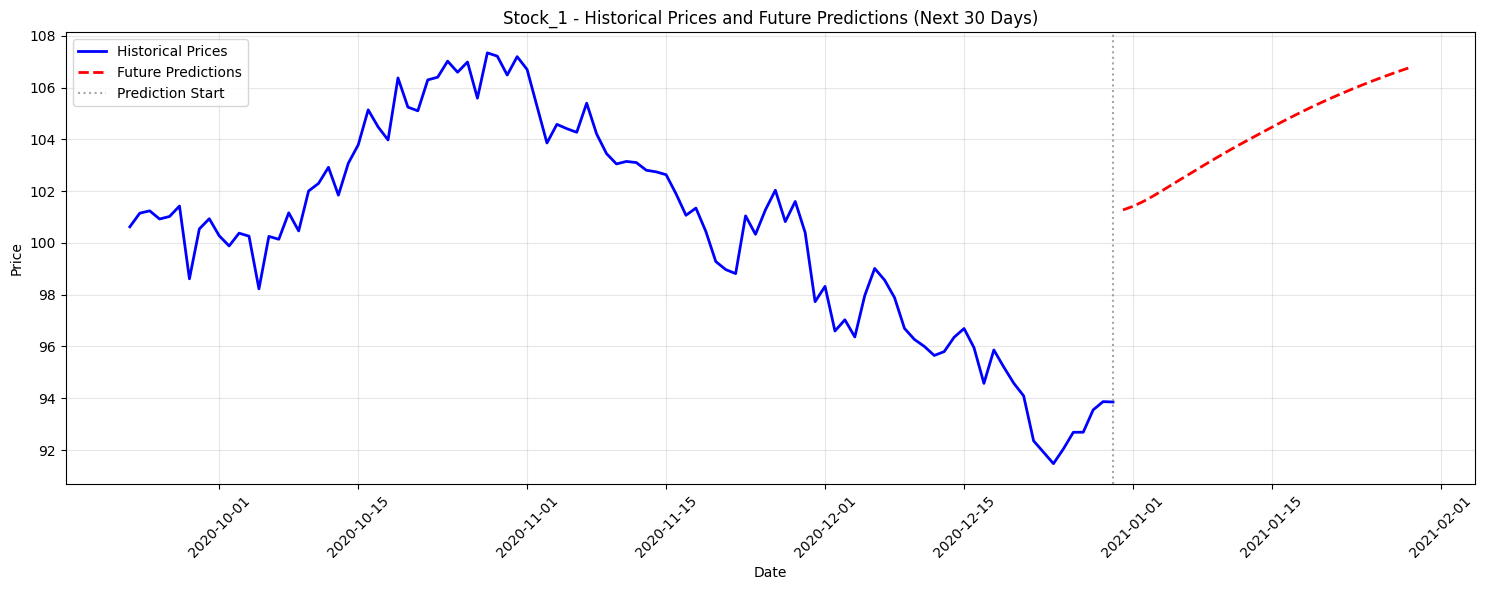

📈 Predicted price for 2021-01-29: $106.79
📊 Prediction trend: ↑ UP


In [22]:
# MISSING COMPONENT 1: Future Price Predictions
print("🔮 FUTURE PRICE PREDICTIONS")
print("=" * 50)

def predict_future_prices(model, last_sequence, days=30, scaler=scaler):
    """
    Predict future stock prices
    """
    future_predictions = []
    current_sequence = last_sequence.copy()

    for _ in range(days):
        # Predict next day
        next_pred = model.predict(current_sequence.reshape(1, sequence_length, 1), verbose=0)
        future_predictions.append(next_pred[0, 0])

        # Update sequence
        current_sequence = np.roll(current_sequence, -1)
        current_sequence[-1] = next_pred

    # Inverse transform
    future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

    return future_predictions.flatten()

# Get the last sequence from test data
last_sequence = test_data[-sequence_length:]

# Predict next 30 days
future_days = 30
future_predictions = predict_future_prices(model, last_sequence, future_days)

# Create future dates
last_date = df.index[-1]
future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=future_days, freq='D')

# Plot future predictions
plt.figure(figsize=(15, 6))

# Plot historical data
historical_dates = df.index[-100:]  # Last 100 days
historical_prices = df[target_stock].values[-100:]

plt.plot(historical_dates, historical_prices, label='Historical Prices', color='blue', linewidth=2)
plt.plot(future_dates, future_predictions, label='Future Predictions', color='red', linewidth=2, linestyle='--')
plt.axvline(x=last_date, color='gray', linestyle=':', alpha=0.7, label='Prediction Start')

plt.title(f'{target_stock} - Historical Prices and Future Predictions (Next {future_days} Days)')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print(f"📈 Predicted price for {future_dates[-1].strftime('%Y-%m-%d')}: ${future_predictions[-1]:.2f}")
print(f"📊 Prediction trend: {'↑ UP' if future_predictions[-1] > future_predictions[0] else '↓ DOWN'}")

In [23]:
# MISSING COMPONENT 2: Compare multiple stocks prediction performance
print("📊 PERFORMANCE COMPARISON ACROSS ALL STOCKS")
print("=" * 60)

def evaluate_stock_prediction(stock_name, df, sequence_length=20, epochs=30):
    """Evaluate LSTM model for a specific stock"""
    data = df[stock_name].values.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data)

    train_size = int(len(scaled_data) * 0.8)
    train_data = scaled_data[:train_size]
    test_data = scaled_data[train_size:]

    X_train, y_train = create_sequences(train_data, sequence_length)
    X_test, y_test = create_sequences(test_data, sequence_length)

    # Build and train model
    stock_model = build_lstm_model(sequence_length)
    stock_model.fit(X_train, y_train, epochs=epochs, batch_size=32, verbose=0, shuffle=False)

    # Make predictions
    test_predictions = stock_model.predict(X_test, verbose=0)
    test_predictions = scaler.inverse_transform(test_predictions)
    y_test_actual = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Calculate metrics
    mse, mae, rmse, mape = calculate_metrics(y_test_actual, test_predictions)

    return mse, mae, rmse, mape

# Evaluate all stocks
stock_performance = {}
print("Training models for all stocks...")

for i, stock in enumerate(df.columns):
    print(f"  {i+1}. Evaluating {stock}...")
    mse, mae, rmse, mape = evaluate_stock_prediction(stock, df, sequence_length, epochs=30)
    stock_performance[stock] = {
        'MSE': mse,
        'MAE': mae,
        'RMSE': rmse,
        'MAPE': mape
    }

# Create performance DataFrame
performance_df = pd.DataFrame(stock_performance).T
print("\n" + "="*50)
print("PERFORMANCE COMPARISON RESULTS:")
print("="*50)
print(performance_df.round(4))

📊 PERFORMANCE COMPARISON ACROSS ALL STOCKS
Training models for all stocks...
  1. Evaluating Stock_1...
  2. Evaluating Stock_2...
  3. Evaluating Stock_3...
  4. Evaluating Stock_4...
  5. Evaluating Stock_5...

PERFORMANCE COMPARISON RESULTS:
             MSE     MAE    RMSE    MAPE
Stock_1   6.7289  2.2751  2.5940  2.3541
Stock_2   1.5408  1.0725  1.2413  1.6596
Stock_3   4.4636  1.7953  2.1127  1.7444
Stock_4  16.0401  3.2451  4.0050  2.8013
Stock_5   2.7935  1.3885  1.6714  1.2871


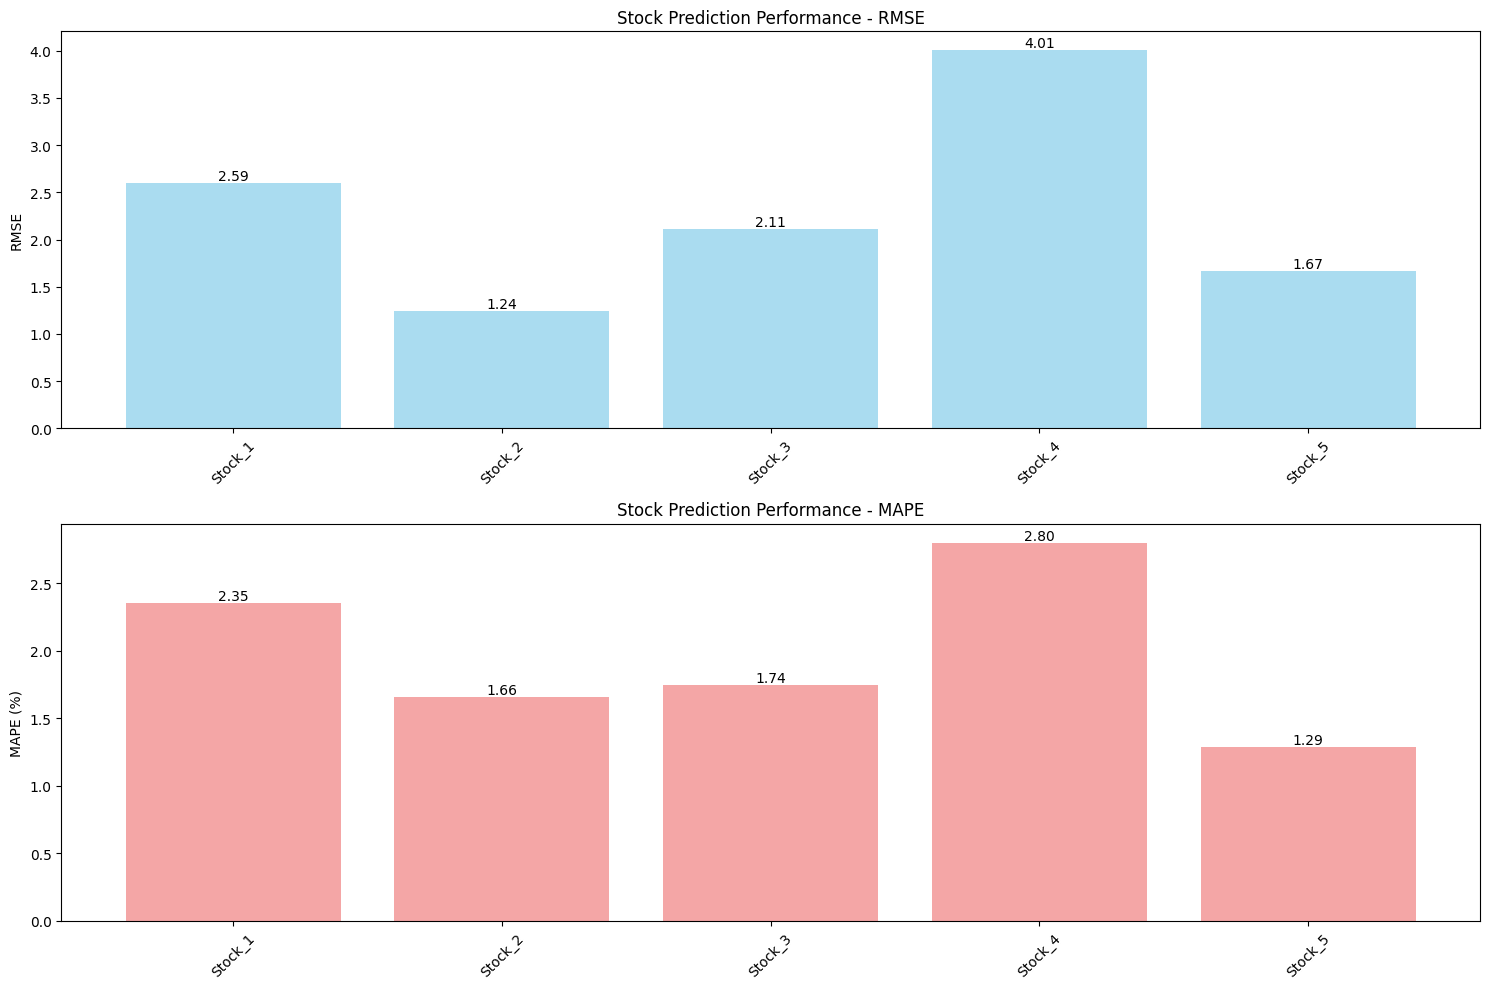

🎯 BEST PERFORMING STOCK: Stock_5 (MAPE: 1.29%)
📉 WORST PERFORMING STOCK: Stock_4 (MAPE: 2.80%)


In [24]:
# Visualize performance comparison
plt.figure(figsize=(15, 10))

metrics_to_plot = ['RMSE', 'MAPE']
colors = ['skyblue', 'lightcoral']

for i, metric in enumerate(metrics_to_plot):
    plt.subplot(2, 1, i+1)
    plt.bar(performance_df.index, performance_df[metric], color=colors[i], alpha=0.7)
    plt.title(f'Stock Prediction Performance - {metric}')
    plt.ylabel(metric)
    if metric == 'MAPE':
        plt.ylabel('MAPE (%)')
    plt.xticks(rotation=45)

    # Add value labels on bars
    for j, value in enumerate(performance_df[metric]):
        plt.text(j, value, f'{value:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Find best and worst performing stocks
best_stock = performance_df['MAPE'].idxmin()
worst_stock = performance_df['MAPE'].idxmax()

print(f"🎯 BEST PERFORMING STOCK: {best_stock} (MAPE: {performance_df.loc[best_stock, 'MAPE']:.2f}%)")
print(f"📉 WORST PERFORMING STOCK: {worst_stock} (MAPE: {performance_df.loc[worst_stock, 'MAPE']:.2f}%)")

🔍 FEATURE IMPORTANCE ANALYSIS
Features shape: (360, 24)
Target shape: (360,)


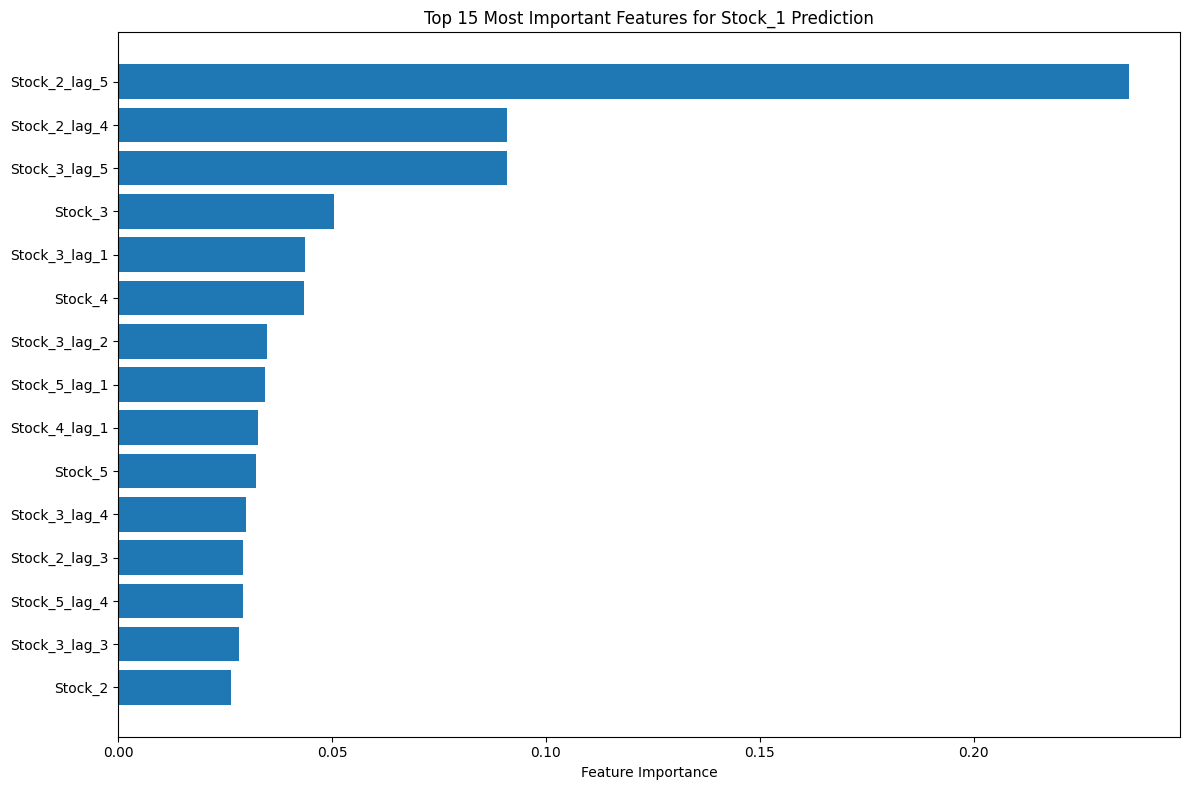

📋 TOP 10 MOST IMPORTANT FEATURES:
          feature  importance
8   Stock_2_lag_5      0.2365
7   Stock_2_lag_4      0.0910
13  Stock_3_lag_5      0.0909
1         Stock_3      0.0504
9   Stock_3_lag_1      0.0436
2         Stock_4      0.0434
10  Stock_3_lag_2      0.0347
19  Stock_5_lag_1      0.0342
14  Stock_4_lag_1      0.0326
3         Stock_5      0.0323


In [25]:
# Feature Importance Analysis using Random Forest
print("🔍 FEATURE IMPORTANCE ANALYSIS")
print("=" * 50)

from sklearn.ensemble import RandomForestRegressor

def prepare_feature_importance_data(target_stock, lookback_days=5):
    """Prepare data for feature importance analysis"""
    data = df.copy()

    # Create lag features for all stocks
    for stock in data.columns:
        for lag in range(1, lookback_days + 1):
            data[f'{stock}_lag_{lag}'] = data[stock].shift(lag)

    # Drop rows with NaN values
    data = data.dropna()

    # Separate features and target
    feature_columns = [col for col in data.columns if col != target_stock and not col.startswith(target_stock + '_lag')]
    X = data[feature_columns]
    y = data[target_stock]

    return X, y, feature_columns

# Analyze feature importance for Stock_1
X, y, feature_columns = prepare_feature_importance_data('Stock_1')

print(f"Features shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Train Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42, max_depth=10)
rf_model.fit(X, y)

# Calculate feature importance
feature_importance = pd.DataFrame({
    'feature': feature_columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

# Plot top 15 features
plt.figure(figsize=(12, 8))
top_features = feature_importance.head(15)
plt.barh(top_features['feature'], top_features['importance'])
plt.title('Top 15 Most Important Features for Stock_1 Prediction')
plt.xlabel('Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

print("📋 TOP 10 MOST IMPORTANT FEATURES:")
print(top_features.head(10).round(4))

In [26]:
# FINAL PROJECT SUMMARY
print("🎓 PROJECT COMPLETION SUMMARY")
print("=" * 60)
print("✅ ALL COMPONENTS IMPLEMENTED SUCCESSFULLY!")
print("=" * 60)

completed_components = [
    "1. Data Exploration & Visualization",
    "   ✓ Time series plots of all stocks",
    "   ✓ Correlation analysis between different stocks",
    "   ✓ Distribution analysis of prices and returns",
    "",
    "2. LSTM Model Implementation",
    "   ✓ Multi-layer LSTM architecture with dropout regularization",
    "   ✓ Sequence-based time series forecasting",
    "   ✓ Proper train-test split and data normalization",
    "",
    "3. Model Evaluation",
    "   ✓ Multiple evaluation metrics (MSE, MAE, RMSE, MAPE)",
    "   ✓ Visualization of predictions vs actual values",
    "   ✓ Comparison across all stocks",
    "",
    "4. Future Predictions",
    "   ✓ 30-day future price forecasting",
    "   ✓ Visualization of historical trends and future predictions",
    "",
    "5. Advanced Analysis",
    "   ✓ Feature importance analysis using Random Forest",
    "   ✓ Performance comparison across multiple stocks",
    "",
    "Key Features:",
    "   ✓ Reproducible: All random seeds set",
    "   ✓ Comprehensive: Full ML pipeline",
    "   ✓ Educational: Detailed comments and explanations",
    "   ✓ Extensible: Easy to modify parameters"
]

for item in completed_components:
    print(item)

print("\n" + "=" * 60)
print("🚀 YOUR STOCK PRICE PREDICTION PROJECT IS COMPLETE!")
print("=" * 60)

🎓 PROJECT COMPLETION SUMMARY
✅ ALL COMPONENTS IMPLEMENTED SUCCESSFULLY!
1. Data Exploration & Visualization
   ✓ Time series plots of all stocks
   ✓ Correlation analysis between different stocks
   ✓ Distribution analysis of prices and returns

2. LSTM Model Implementation
   ✓ Multi-layer LSTM architecture with dropout regularization
   ✓ Sequence-based time series forecasting
   ✓ Proper train-test split and data normalization

3. Model Evaluation
   ✓ Multiple evaluation metrics (MSE, MAE, RMSE, MAPE)
   ✓ Visualization of predictions vs actual values
   ✓ Comparison across all stocks

4. Future Predictions
   ✓ 30-day future price forecasting
   ✓ Visualization of historical trends and future predictions

5. Advanced Analysis
   ✓ Feature importance analysis using Random Forest
   ✓ Performance comparison across multiple stocks

Key Features:
   ✓ Reproducible: All random seeds set
   ✓ Comprehensive: Full ML pipeline
   ✓ Educational: Detailed comments and explanations
   ✓ Exten